**Introduction**

In this project, my goal is to develop a robust multilabel classification model that predicts clothing product attributes based on consumer reviews. The dataset, sourced from various channels, comprises an extensive collection of apparel product reviews. Each data entry is meticulously annotated with labels representing materials, construction, color, finishing, and durability.

The richness of perspectives and opinions within the dataset should enable us to explore and evaluate classification models effectively. Multilabel classification is essential for capturing the multifaceted nature of customer feedback, allowing the model to predict multiple categories for each review. Ultimately, this research contributes to advancing the application of machine learning algorithms in the fashion industry.

**Author**: Julia Poteralska


I will use the dataset from kaggle: https://www.kaggle.com/datasets/jocelyndumlao/consumer-review-of-clothing-product.

---



# How to run the code?

**Import libraries**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import ParameterGrid

**Mount the drive and change the directory**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "drive/MyDrive/Classroom/Introduction to Deep Learning for NLP (2024)"
# here you need to insert path to your current directory, where you keep the data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/Classroom/Introduction to Deep Learning for NLP (2024)'
/content/drive/MyDrive/Classroom/Introduction to Deep Learning for NLP (2024)


**Load dataset**

In [ ]:
ds = pd.read_csv('data_amazon.xlsx - Sheet1.csv') # write the name of your file

# Input characteristics

**Explore dataset**

Load the dataset and perform initial preprocessing steps, including handling missing values, combining text fields, and encoding labels. Explore the dataset to understand its structure and distribution. This includes visualizing the distribution of categories and analyzing the text data.


In [ ]:
ds.head() # let's see what our dataset looks like

,Title,Review,Cons_rating,Cloth_class,Materials,Construction,Color,Finishing,Durability
0,NaN,Absolutely wonderful - silky and sexy and comf...,4.0,Intimates,0.0,0.0,0.0,1.0,0.0
1,NaN,Love this dress! it's sooo pretty. i happene...,5.0,Dresses,0.0,1.0,0.0,0.0,0.0
2,Some major design flaws,I had such high hopes for this dress and reall...,3.0,Dresses,0.0,0.0,0.0,1.0,0.0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5.0,Pants,0.0,0.0,0.0,0.0,0.0
4,Flattering shirt,This shirt is very flattering to all due to th...,5.0,Blouses,0.0,1.0,0.0,0.0,0.0


In [ ]:
len(ds) # let's see how many rows there are

49338

In [ ]:
row_indices, col_indices = np.where(pd.isnull(ds)) # check for a missing data
row_indices, col_indices

(array([    0,     1,    11, ..., 49284, 49284, 49299]),
 array([0, 0, 0, ..., 7, 8, 8]))

In [ ]:
ds = ds.dropna() # I will delete the missing values

In [ ]:
sum(ds["Review"].duplicated()) # I'm going to check for duplicates based on reviews, because they are more unique

28

In [ ]:
ds = ds.drop_duplicates(subset="Review")
sum(ds["Review"].duplicated()) # I deleted duplicates from the data

0

In [ ]:
empty_string_indices = np.where(ds.applymap(lambda x: x == '')) # let's check for values that are empty strings
empty_string_indices # There are no empty strings

(array([], dtype=int64), array([], dtype=int64))

**Data distribution by categories**

In [ ]:
n = 5 # determine the number of categories

list_categories = ds.columns.tolist()[-n:] # let's see what categories are in the dataset
list_categories

['Materials', 'Construction', 'Color', 'Finishing', 'Durability']

In [ ]:
# Building the distribution dataframe
data_distribution = ds[list_categories].value_counts().reset_index()
data_distribution.columns = list_categories + ['number of occurrences']
data_distribution = data_distribution[['number of occurrences'] + list_categories]

data_distribution.style.apply(lambda x: ['background-color: yellow']*len(x) if x.name == 'number of occurrences' else ['']*len(x), axis=0)

,number of occurrences,Materials,Construction,Color,Finishing,Durability
0,1060,0.000000,1.000000,0.000000,0.000000,0.000000
1,519,0.000000,0.000000,0.000000,0.000000,1.000000
2,475,0.000000,0.000000,0.000000,0.000000,0.000000
3,420,1.000000,1.000000,0.000000,0.000000,0.000000
4,357,0.000000,1.000000,0.000000,1.000000,0.000000
5,293,0.000000,1.000000,1.000000,0.000000,0.000000
6,269,1.000000,0.000000,0.000000,0.000000,0.000000
7,247,0.000000,0.000000,1.000000,0.000000,0.000000
8,216,0.000000,0.000000,0.000000,1.000000,0.000000
9,170,1.000000,0.000000,1.000000,0.000000,0.000000


The table above outlines the distribution of various combinations of labels and their occurrences. Based on it, it can be observed that:
- Some combinations of labels are much more frequent than others. The table shows an imbalanced distribution of labels.
- Labels like Construction and Durability are often present in high-frequency combinations.
- Certain combinations with multiple labels are relatively rare.

In [ ]:
print(sum(ds[list_categories].value_counts() <= 5))

3


There are 3 combinations that have few occurrences.

Now, because it would be helpful later while stratifying, I will delete the combinations with occurrences <=1.

In [ ]:
infrequent_combinations = data_distribution[data_distribution['number of occurrences'] <= 1] # combinations with number of occurrences <= 1
merged = ds.reset_index().merge(infrequent_combinations[list_categories], on=list_categories, how='inner') #identify the rows
indexes_to_remove = merged['index']

ds = ds.drop(indexes_to_remove)

In [ ]:
print(sum(ds[list_categories].value_counts() <= 5))

1


**Building input text and labels**

In [ ]:
text = ds['Title'] + ds['Review']
text = text.astype(str)
labels = ds[list_categories].values

In [ ]:
text.apply(lambda x: len(x.split(" "))).describe() # let's see a summary of number of words in each row

count    5412.000000
mean       41.415558
std        33.114214
min         1.000000
25%        16.000000
50%        32.000000
75%        58.000000
max       365.000000
dtype: float64

*Observations:*
- The average review length is approximately 41 words, but the median review
length is 32 words. This indicates a right-skewed distribution where a smaller number of reviews have significantly more words than the average.
- The standard deviation of 33.11 suggests a high degree of variability in review lengths. Some reviews are much longer or shorter than the mean.
- The interquartile range (IQR), which is the difference between the 75th percentile and the 25th percentile, is 42 words (58 - 16), showing the middle 50% of reviews vary widely in length.
- The shortest review contains only 1 word, while the longest review contains 365 words. This large range (1 to 365) indicates a significant spread in the data.


Based on my observations I will choose the vocabulary size and output sentence length in the next step.

**Tokenizer process**

In [ ]:
voc_size = 5000 # because my dataset consists 5412 reviews
tokenizer = tf.keras.layers.TextVectorization(max_tokens=voc_size, output_sequence_length=70) # output_sequence_length it's over 75th percentile

tokenizer.adapt(text) #let's create a vocabulary
vocabulary = tokenizer.get_vocabulary()

print(vocabulary)

['', '[UNK]', 'the', 'and', 'i', 'it', 'a', 'is', 'to', 'this', 'in', 'for', 'but', 'dress', 'of', 'was', 'not', 'on', 'so', 'very', 'my', 'with', 'love', 'that', 'great', 'have', 'fit', 'like', 'are', 'color', 'as', 'wear', 'size', 'be', 'too', 'comfortable', 'fabric', 'its', 'just', 'you', 'me', 'or', 'at', 'up', 'they', 'one', 'perfect', 'material', 'cute', 'would', 'nice', 'quality', 'flattering', 'top', 'more', 'soft', 'if', 'well', 'good', 'will', 'am', 'sweater', 'really', 'little', 'all', 'fits', 'them', 'ordered', 'small', 'out', 'had', 'these', 'because', 'bought', 'than', 'im', 'beautiful', 'look', 'after', 'colors', 'got', 'can', 'it’s', 'looks', 'super', 'an', 'when', 'pretty', 'has', 'bit', 'back', 'much', 'large', 'down', 'also', 'no', 'made', 'work', 'only', 'pants', 'even', 'about', 'buy', 'from', 'get', 'long', 'which', 'medium', 'shirt', 'were', 'first', 'summer', 'see', 'loved', 'time', 'black', 'wearing', 'comfy', 'there', 'way', 'length', 'what', 'big', 'did', 'ri

**Splitting for train and test datasets**

In [ ]:
X = tokenizer(text).numpy()
Y = labels

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify = Y, shuffle=True)

Using stratify and shuffle ensures that the training and test sets are both representative of the overall dataset and is crucial for model evaluation. Stratification maintains class balance, while shuffling eliminates sequence bias. Together, they enhance the reliability of machine learning results.

I chose test_size=0.1 to ensure that the model has a substantial amount of data to learn from.

# The process of training

**Recurrent Unit**

In [ ]:
class Rec_Unit(tf.keras.Model):
    '''
    Embedding arguments (args):
    input_dim: <int> (Size of the vocabulary)
    output_dim: <int> (Dimension of the dense embedding)
    '''
    def __init__(self, num_classes, units, args, Utype):
        super().__init__()
        rec_type = {'RNN': tf.keras.layers.SimpleRNN,
                    'LSTM': tf.keras.layers.LSTM,
                    'GRU': tf.keras.layers.GRU}
        # embeddings
        self.embedding_layer = tf.keras.layers.Embedding(**args, name='input_layer')
        self.hidden_layer = rec_type[Utype](units=units, activation=tf.nn.tanh, return_sequences=True, name='recurrent_layer')
        self.pool_layer = tf.keras.layers.GlobalMaxPool1D(name='pool_layer')
        self.dense_layer = tf.keras.layers.Dense(units=50, activation=tf.nn.relu, name='dense_layer')
        # classifier
        self.output_layer = tf.keras.layers.Dense(units=num_classes, activation=tf.nn.sigmoid, name='output_layer')

    def call(self, inputs):
        x = self.embedding_layer(inputs)
        x = self.hidden_layer(x)
        x = self.pool_layer(x)
        x = self.dense_layer(x)
        return self.output_layer(x)

**Recurrent Neural Network**

In [ ]:
class Recurrent_Model:
    def __init__(self, X, Y, units=2, Utype='RNN', args={'input_dim':100, 'output_dim':4}):
        self.X = X
        self.Y = Y
        self.model = Rec_Unit(Y.shape[1], units, args, Utype)

    # train the model
    def train(self, LR, epochs, batch_size=32, verbose=0, validation_split=None):
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                           loss=tf.keras.losses.BinaryCrossentropy(),
                           metrics=['accuracy'])
        self.loss_acc = self.model.fit(self.X, self.Y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=validation_split)

    # plot loss and accuracy history
    def plot_loss_accuracy(self):
        fig = plt.figure(figsize=(8, 4))
        fig.suptitle('Log Loss and Accuracy over Epochs')
        labels = ['Training', 'Validation']

        # get training history to plot
        loss = self.loss_acc.history.get('loss')
        val_loss = self.loss_acc.history.get('val_loss')
        accuracy = self.loss_acc.history.get('accuracy')
        val_accuracy = self.loss_acc.history.get('val_accuracy')

        # add_subplot(nrows, ncolumns, index)
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(loss, label=labels[0])
        if val_loss:
            ax.plot(val_loss, label=labels[1])
        ax.grid(True)
        ax.set(xlabel='Epochs', title='Log Loss')
        ax.legend(loc='upper right')

        ax = fig.add_subplot(1, 2, 2)
        ax.plot(accuracy, label=labels[0])
        if val_accuracy:
            ax.plot(val_accuracy, label=labels[1])
        ax.grid(True)
        ax.set(xlabel='Epochs', title='Accuracy')
        ax.legend(loc='lower right')

**Defining and training a model**

Performing hyperparameter tuning to find the best architecture and parameters. This includes experimenting with different numbers of layers, units, learning rates batch sizes, and types of recurrent neural networks.

In [ ]:
param_grid = {
    'units': [32, 64, 128],
    'Utype': ['RNN', 'LSTM', 'GRU'],
    'LR': [0.001, 0.01, 0.05],
    'batch_size': [64, 128, 256],
    'epochs': [2, 5, 10],
    'input': [5000, 7000, 10000],
    'output': [128, 256, 512]
}

best_score = 0
best_params = None

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    rec = Recurrent_Model(X=X_train, Y=Y_train, units=32, Utype=params['Utype'],
                            args={'input_dim': params['input'], 'output_dim': params['output']})
    history = rec.train(LR=params['LR'], epochs=params['epochs'], batch_size=params['batch_size'])
    score = rec.model.evaluate(X_test, Y_test, verbose=0)[1]
    if score > best_score:
        best_score = score
        best_params = params

print(f"Best score: {best_score}")
print(f"Best parameters: {best_params}")

Testing parameters: {'LR': 0.01, 'Utype': 'LSTM', 'batch_size': 256, 'epochs': 2, 'input': 7000, 'output': 256, 'units': 64}
Best score: 0.48708486557006836
Best parameters: {'LR': 0.01, 'Utype': 'LSTM', 'batch_size': 256, 'epochs': 2, 'input': 7000, 'output': 256, 'units': 64}


In [ ]:
rec = Recurrent_Model(X=X_train, Y=Y_train, units=64, Utype='LSTM',
                      args={'input_dim':7000, 'output_dim':256})

rec.model.build(input_shape=X_train.shape)
rec.model.summary()

Model: "rec__unit_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Embedding)     multiple                  1792000   
                                                                 
 recurrent_layer (LSTM)      multiple                  82176     
                                                                 
 pool_layer (GlobalMaxPooli  multiple                  0         
 ng1D)                                                           
                                                                 
 dense_layer (Dense)         multiple                  3250      
                                                                 
 output_layer (Dense)        multiple                  255       
                                                                 
Total params: 1877681 (7.16 MB)
Trainable params: 1877681 (7.16 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
lr = 0.01
epochs = 2
batch_size = 256

rec.train(LR=lr, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2)

Epoch 1/2
16/16 [==============================] - 11s 386ms/step - loss: 0.5470 - accuracy: 0.3806 - val_loss: 0.4199 - val_accuracy: 0.5041
Epoch 2/2
16/16 [==============================] - 7s 466ms/step - loss: 0.3378 - accuracy: 0.5046 - val_loss: 0.3216 - val_accuracy: 0.5246


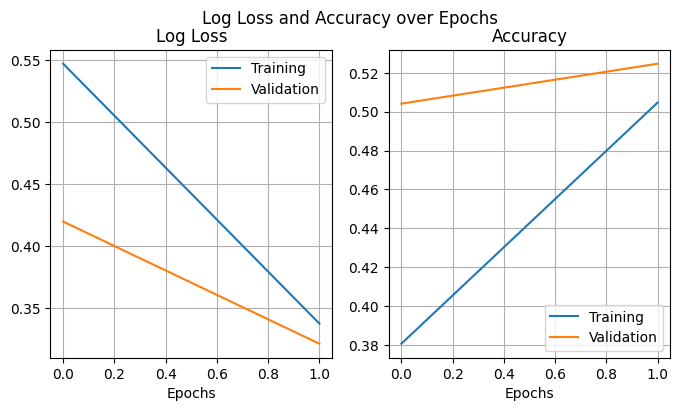

In [ ]:
rec.plot_loss_accuracy()

The dataset was split into 90% for training and 10% for testing, using stratified sampling to maintain the proportion of labels in both sets.

A recurrent neural network model(RNN) was used for this task. It allows for flexibility in choosing the type of recurrent unit (e.g., plain RNN, LSTM, GRU). There are five layers (embedding, hidden, pool, dense and output) with different activation functions (like tanh, relu and sigmoid). An embedding layer was used with a vocabulary size of 7 000 and an embedding dimension of 256.

A grid search was conducted to identify the optimal hyperparameters. The final model was trained with a learning rate of 0.01, a batch size of 256, Utype of LSTM and 64 units. The model was trained for 2 epochs using the Adam optimizer and binary cross-entropy loss function, appropriate for multi-label classification.

# The final results

**Accuracy for multilabel classification**

I need to create a function to compute the accuracy, because evaluate function doesn't show what is wanted in a multilabel classification.

In [ ]:
def acc(c,t):
    if t == 0:
        return 0.0
    else:
        return np.round((c/t)*100, decimals=1)

In [ ]:
def multilabel_accuracy(answer, prediction):
    N = len(answer)
    correct = 0
    for i in range(N):
        if all(answer[i] == np.round(prediction[i])):
            correct += 1

    return correct/N

In [ ]:
prediction = rec.model.predict(X_test, verbose=0) # computed predictions

In [ ]:
multilabel_accuracy(Y_test, prediction) # computed accuracy for multilabel classification

0.5313653136531366

**Average performance**

In [ ]:
def average_performance(runs=5, test=0.1):
     lr = 0.01
     epochs = 2
     batch_size = 256

     models = []
     best = 0
     for _ in range(runs):
         X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test, stratify=Y, shuffle=True)

         rec = Recurrent_Model(X=X_train, Y=Y_train, units=64, Utype='LSTM',
                      args={'input_dim':7000, 'output_dim':256})
         rec.train(LR=lr, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2)

         prediction = rec.model.predict(X_test, verbose=0)
         accuracy = multilabel_accuracy(Y_test, prediction)
         models.append(accuracy)
         if accuracy > best:
            best = accuracy

     average_accuracy = np.mean(models)
     sd = np.std(models)
     return (f"Average accuracy = {average_accuracy}"), (f"Standard deviation = {sd}"), (f"Best accuracy = {best}")

In [ ]:
average_performance(runs=10)

Epoch 1/2
16/16 [==============================] - 11s 501ms/step - loss: 0.5871 - accuracy: 0.3445 - val_loss: 0.5140 - val_accuracy: 0.3809
Epoch 2/2
16/16 [==============================] - 6s 374ms/step - loss: 0.4020 - accuracy: 0.5062 - val_loss: 0.3071 - val_accuracy: 0.5606
Epoch 1/2
16/16 [==============================] - 12s 476ms/step - loss: 0.5721 - accuracy: 0.4032 - val_loss: 0.5054 - val_accuracy: 0.4487
Epoch 2/2
16/16 [==============================] - 8s 514ms/step - loss: 0.4260 - accuracy: 0.5128 - val_loss: 0.3614 - val_accuracy: 0.5092
Epoch 1/2
16/16 [==============================] - 13s 677ms/step - loss: 0.5635 - accuracy: 0.3747 - val_loss: 0.4477 - val_accuracy: 0.4589
Epoch 2/2
16/16 [==============================] - 6s 368ms/step - loss: 0.3481 - accuracy: 0.5259 - val_loss: 0.3272 - val_accuracy: 0.6232
Epoch 1/2
16/16 [==============================] - 11s 442ms/step - loss: 0.5745 - accuracy: 0.4068 - val_loss: 0.5143 - val_accuracy: 0.4969
Epoch 2/2

('Average accuracy = 0.46549815498154984',
 'Standard deviation = 0.060228196292100834',
 'Best accuracy = 0.5387453874538746')

**Table to summarize results**

In [ ]:
def summary_table(multi_labels, answer, prediction, train):
    # compute accuracies by classes in a dictionary
    N = len(answer)
    d = {ml: [0, 0, 0] for ml in multi_labels}  # [Test Data, Correct Predictions, Training Data]

    for i in range(N):
        c = ''.join([str(b) for b in answer[i]])
        d[c][0] += 1
        if all(np.round(prediction[i]) == answer[i]):
            d[c][1] += 1
        k = ''.join([str(j) for j in train[i]])
        d[k][2] += 1

    # create table
    columns = ['Label', 'Total data', 'Training data', 'Test data', 'Correct predictions', 'Accuracy']
    table = [[k, v[0] + v[2], v[2], v[0], v[1], acc(v[1], v[0])] for k, v in d.items()]

    return pd.DataFrame(table, columns=columns)

In [ ]:
# Computed accuracy by classes
multi_labels = data_distribution[list_categories].apply(lambda x: ''.join(x.astype(str)), axis=1)
df = summary_table(multi_labels, Y_test, prediction, Y_train)
df

,Label,Total data,Training data,Test data,Correct predictions,Accuracy
0,0.01.00.00.00.0,206,100,106,77,72.6
1,0.00.00.00.01.0,107,55,52,44,84.6
2,0.00.00.00.00.0,106,58,48,29,60.4
3,1.01.00.00.00.0,80,38,42,18,42.9
4,0.01.00.01.00.0,73,37,36,14,38.9
5,0.01.01.00.00.0,64,35,29,16,55.2
6,1.00.00.00.00.0,63,36,27,12,44.4
7,0.00.01.00.00.0,43,18,25,16,64.0
8,0.00.00.01.00.0,36,14,22,9,40.9
9,1.00.01.00.00.0,37,20,17,7,41.2


In [ ]:
np.mean(df["Test data"])

15.941176470588236

In [ ]:
np.mean(df["Correct predictions"])

8.470588235294118

**Project Results Summary:**
- Average multi-label accuracy: Approximately 0.47%, indicating a moderate ability of the model to correctly predict product attributes based on consumer reviews.
- Standard deviation: Approximately 0.06%, indicating that variability in accuracy across different labels or test models is low.
- Best accuracy: Achieved an accuracy of around 0.54%, indicating that at least one label or model achieved a higher rate of correct predictions.

The model's accuracy varies across different label combinations. Some combinations, like "00001", show high accuracy (84.6%), while others have an accuracy of 0.0%, indicating that the model struggles to predict certain label combinations correctly. High-performing combinations generally have more instances, suggesting that the model benefits from having more data to learn from.

Generally, it can be seen that combinations with multiple categories performed worse, than those with one or two categories.
Model failed to make any correct predictions for some combinations. This could be due to the small number of instances in the training set for these combinations, making it difficult for the model to learn and generalize.

My model is not perfect, it has room for improvement. Challenges such as dealing with unbalanced data were encountered, which affected the model's ability to accurately classify reviews into relevant categories. However, these results provide valuable insights into the model's strengths and weaknesses, guiding future improvements in handling label imbalances and enhancing overall prediction accuracy.
